/tmp/ipykernel_10377/1298871512.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  u_rep += 0.5 * k_rep * (1/dist - 1/rho_0)**2


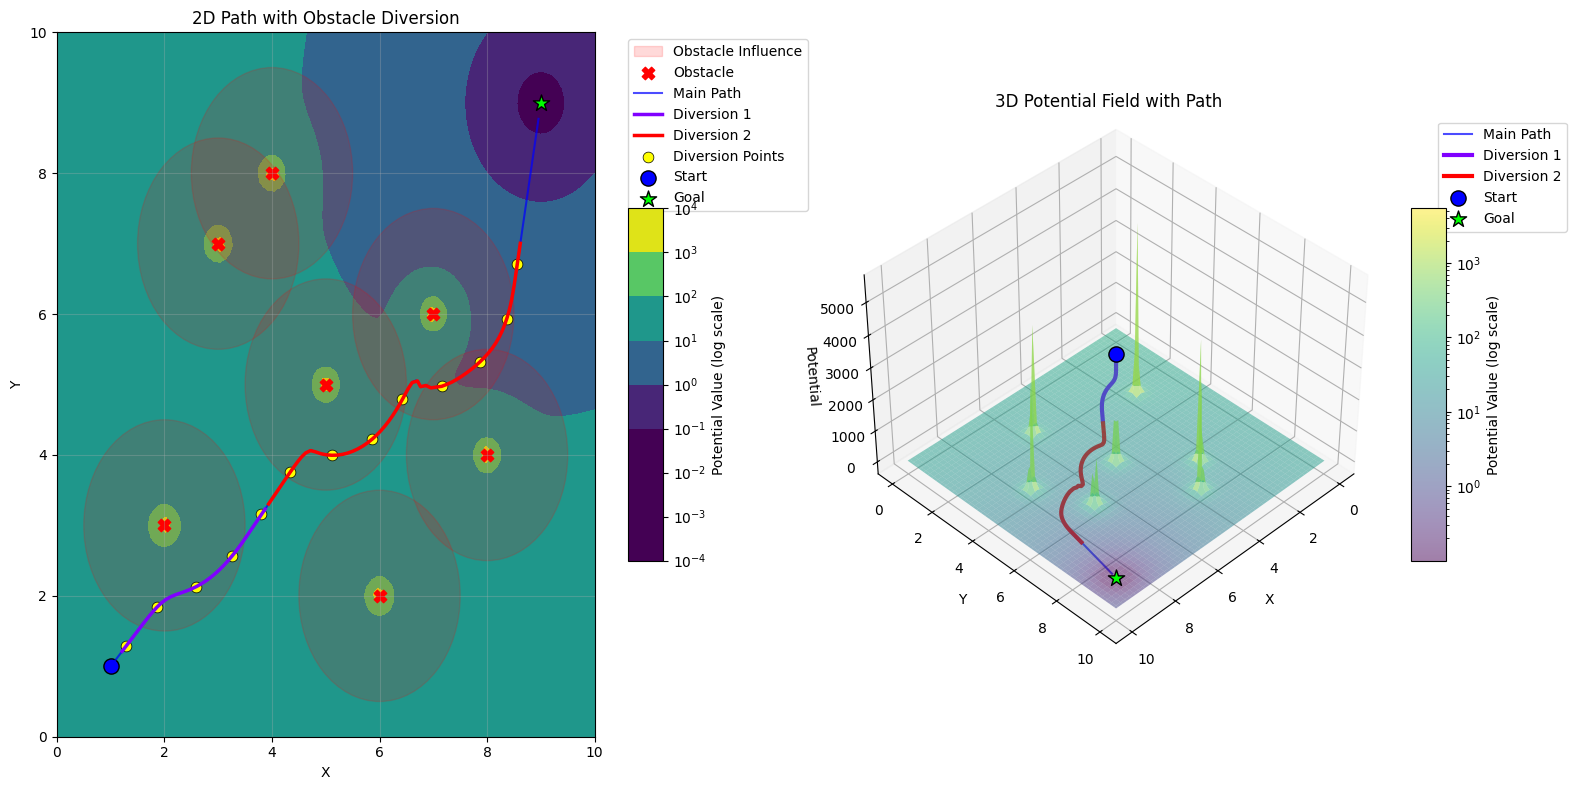

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle
import matplotlib.colors as colors
from scipy.interpolate import make_interp_spline  # For path smoothing

def main():
    # Parameters
    workspace_size = (10, 10)
    start = (1, 1)
    goal = (9, 9)
    obstacles = [(2, 3), (3, 7), (5, 5), (6, 2), (7, 6), (8, 4), (4, 8)]
    k_att = 1.0
    k_rep = 15.0
    rho_0 = 1.5
    step_size = 0.1
    max_steps = 1000

    # Potential field calculations
    def attractive_potential(pos, goal, k_att):
        return 0.5 * k_att * np.linalg.norm(np.array(pos) - np.array(goal))**2

    def repulsive_potential(pos, obstacles, k_rep, rho_0):
        u_rep = 0
        for obs in obstacles:
            dist = np.linalg.norm(np.array(pos) - np.array(obs))
            if dist <= rho_0:
                u_rep += 0.5 * k_rep * (1/dist - 1/rho_0)**2
        return u_rep

    def total_potential(pos, goal, obstacles, k_att, k_rep, rho_0):
        return (attractive_potential(pos, goal, k_att) + 
                repulsive_potential(pos, obstacles, k_rep, rho_0))

    # Create potential field grid
    x_vals = np.linspace(0, workspace_size[0], 100)
    y_vals = np.linspace(0, workspace_size[1], 100)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i,j] = total_potential((X[i,j], Y[i,j]), goal, obstacles, k_att, k_rep, rho_0)

    # Path planning with obstacle avoidance
    def plan_path(start, goal, obstacles, workspace_size, k_att, k_rep, rho_0, step_size, max_steps):
        path = [np.array(start)]
        diversion_points = []
        diversion_segments = []
        current_segment = [np.array(start)]
        
        for _ in range(max_steps):
            current = path[-1]
            
            if np.linalg.norm(current - goal) < 0.3:
                break
                
            # Adaptive step size for gradient calculation
            eps = max(0.01, min(0.1, np.linalg.norm(current - goal)/10))
            dx = (total_potential(current + [eps, 0], goal, obstacles, k_att, k_rep, rho_0) - 
                  total_potential(current - [eps, 0], goal, obstacles, k_att, k_rep, rho_0)) / (2*eps)
            dy = (total_potential(current + [0, eps], goal, obstacles, k_att, k_rep, rho_0) - 
                  total_potential(current - [0, eps], goal, obstacles, k_att, k_rep, rho_0)) / (2*eps)
            
            grad = np.array([dx, dy])
            grad_norm = np.linalg.norm(grad)
            
            # Obstacle detection and tracking
            near_obstacle = any(np.linalg.norm(current - obs) < rho_0*1.3 for obs in obstacles)
            
            if near_obstacle:
                if not diversion_points or np.linalg.norm(current - diversion_points[-1]) > rho_0*0.5:
                    diversion_points.append(current.copy())
                current_segment.append(current.copy())
            else:
                if len(current_segment) > 1:
                    diversion_segments.append(np.array(current_segment))
                current_segment = [current.copy()]
            
            if grad_norm > 0:
                direction = -grad / grad_norm
            else:
                direction = np.random.normal(0, 0.1, 2)
                if np.linalg.norm(direction) > 0:
                    direction = direction / np.linalg.norm(direction)
                    
            next_pos = current + step_size * direction
            
            if (next_pos[0] < 0 or next_pos[0] > workspace_size[0] or 
                next_pos[1] < 0 or next_pos[1] > workspace_size[1]):
                break
                
            path.append(next_pos)
        
        # Apply path smoothing
        if len(path) > 3:
            t = np.linspace(0, 1, len(path))
            spl = make_interp_spline(t, np.array(path), k=3)
            smoothed_path = spl(np.linspace(0, 1, len(path)*2))
            return smoothed_path, diversion_points, diversion_segments
        
        return np.array(path), diversion_points, diversion_segments

    # Generate path
    path, diversion_points, diversion_segments = plan_path(
        start, goal, obstacles, workspace_size, k_att, k_rep, rho_0, step_size, max_steps
    )
    path_x, path_y = path.T

    # Visualization
    plt.figure(figsize=(16, 8))

    # 2D Visualization
    ax1 = plt.subplot(1, 2, 1)
    norm = colors.LogNorm(vmin=Z.min()+0.1, vmax=Z.max())
    contour = ax1.contourf(X, Y, Z, levels=20, cmap='viridis', norm=norm)
    plt.colorbar(contour, ax=ax1, shrink=0.5, aspect=10, label='Potential Value (log scale)')

    # Draw obstacles and influence zones
    for obs in obstacles:
        ax1.add_patch(Circle(obs, rho_0, color='red', alpha=0.15, 
                          label='Obstacle Influence' if obs == obstacles[0] else ""))
        ax1.scatter(obs[0], obs[1], color='red', s=80, marker='X', 
                   label='Obstacle' if obs == obstacles[0] else "")

    # Plot path and diversions
    ax1.plot(path_x, path_y, 'b-', linewidth=1.5, alpha=0.7, label='Main Path')
    
    color_list = plt.cm.rainbow(np.linspace(0, 1, len(diversion_segments)))
    for i, segment in enumerate(diversion_segments):
        seg_x, seg_y = segment.T
        ax1.plot(seg_x, seg_y, color=color_list[i], linewidth=2.5, 
                label=f'Diversion {i+1}' if i < 3 else "")

    if diversion_points:
        div_x, div_y = zip(*diversion_points)
        ax1.scatter(div_x, div_y, color='yellow', s=60, edgecolors='black', 
                   linewidths=0.5, label='Diversion Points')

    ax1.scatter(start[0], start[1], color='blue', s=120, marker='o', 
               edgecolor='black', linewidth=1, label='Start')
    ax1.scatter(goal[0], goal[1], color='lime', s=150, marker='*', 
               edgecolor='black', linewidth=1, label='Goal')

    ax1.set(xlabel='X', ylabel='Y', title='2D Path with Obstacle Diversion')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)

    # 3D Visualization
    ax2 = plt.subplot(1, 2, 2, projection='3d')
    surf = ax2.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5, norm=norm)
    plt.colorbar(surf, ax=ax2, shrink=0.5, aspect=10, label='Potential Value (log scale)')

    path_z = [total_potential(p, goal, obstacles, k_att, k_rep, rho_0) for p in path]
    ax2.plot(path_x, path_y, path_z, 'b-', linewidth=1.5, alpha=0.7, label='Main Path')

    for i, segment in enumerate(diversion_segments):
        seg_z = [total_potential(p, goal, obstacles, k_att, k_rep, rho_0) for p in segment]
        ax2.plot(*segment.T, seg_z, color=color_list[i], linewidth=3, 
                label=f'Diversion {i+1}' if i < 3 else "")

    for obs in obstacles:
        obs_z = total_potential(obs, goal, obstacles, k_att, k_rep, rho_0)
        ax2.scatter(obs[0], obs[1], obs_z, color='red', s=80, marker='X')

    ax2.scatter(start[0], start[1], total_potential(start, goal, obstacles, k_att, k_rep, rho_0), 
               color='blue', s=120, marker='o', edgecolor='black', label='Start')
    ax2.scatter(goal[0], goal[1], total_potential(goal, goal, obstacles, k_att, k_rep, rho_0), 
               color='lime', s=150, marker='*', edgecolor='black', label='Goal')

    ax2.set(xlabel='X', ylabel='Y', zlabel='Potential', 
           title='3D Potential Field with Path')
    ax2.view_init(elev=40, azim=45)
    ax2.legend(bbox_to_anchor=(1.1, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

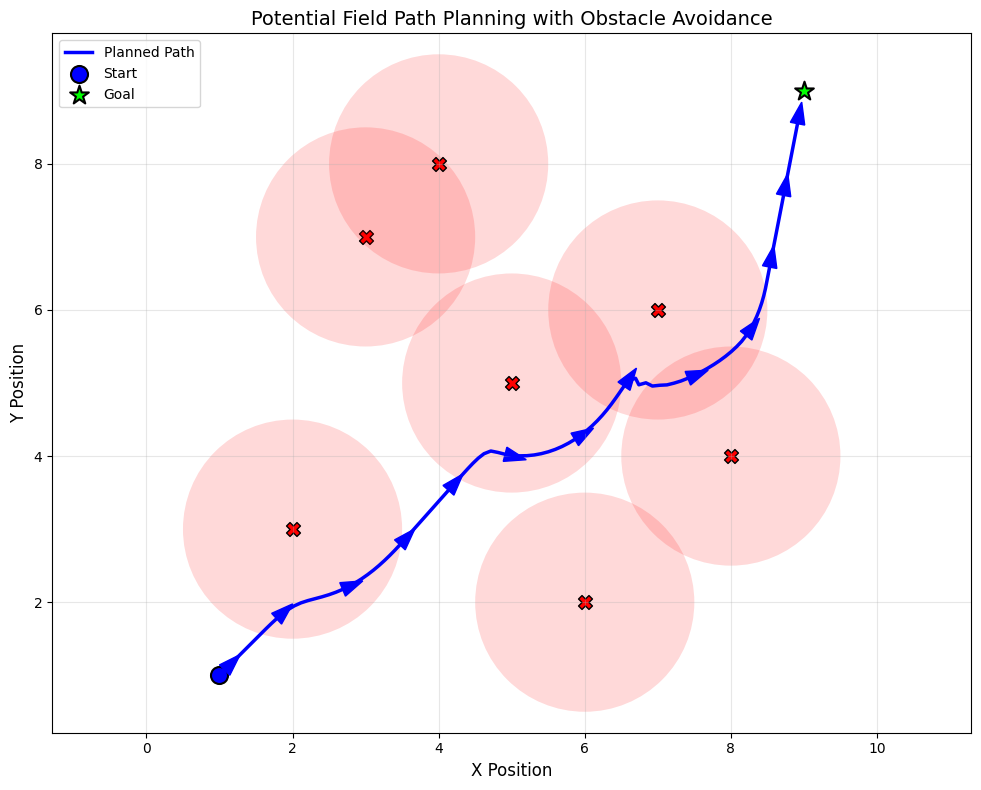

In [28]:



# Generate the path
path = plan_path(start, goal, obstacles, workspace_size, k_att, k_rep, rho_0)
path_x, path_y = path.T

# Create the 2D plot
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Draw obstacle influence zones and centers
for obs in obstacles:
    ax.add_patch(Circle(obs, rho_0, color='red', alpha=0.15, linewidth=0))
    plt.scatter(obs[0], obs[1], color='red', s=100, marker='X', edgecolors='black', linewidths=1)

# Draw the planned path
plt.plot(path_x, path_y, 'b-', linewidth=2.5, label='Planned Path')

# Mark start and goal points
plt.scatter(start[0], start[1], color='blue', s=150, marker='o', edgecolors='black', linewidths=1.5, label='Start')
plt.scatter(goal[0], goal[1], color='lime', s=200, marker='*', edgecolors='black', linewidths=1.5, label='Goal')

# Add directional arrows
for i in range(0, len(path_x) - 1, 10):
    dx = path_x[i + 1] - path_x[i]
    dy = path_y[i + 1] - path_y[i]
    plt.arrow(path_x[i], path_y[i], dx, dy, head_width=0.2, head_length=0.3, fc='blue', ec='blue')

# Plot formatting
plt.xlabel('X Position', fontsize=12)
plt.ylabel('Y Position', fontsize=12)
plt.title('Potential Field Path Planning with Obstacle Avoidance', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=10)
plt.axis('equal')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.tight_layout()
plt.show()
